## Set Up

In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.4/328.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.1 MB/s eta 0:00:00


In [ ]:
import nltk

nltk.download('punkt')

from nltk.tokenize import sent_tokenize
import json

import os

import ast
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from openai import OpenAI

client = OpenAI(api_key='##')

In [ ]:
emotions = [ "fear", "surprise", "joy", "trust",
           "sadness", "anticipation", "anger", "disgust"]

prompt = """ Hi, I have a text which is the auto-transcription of an interview in Finnish.
The interview happens between two adults.
They are talking about an experiment they did last week,
which was teaching kids on zoom or on a VR platform. I need to identify lines containing One EMOTION
from this text. Specifically, I need the character positions
(beginning and end) of sentences that express The EMOTION.

Please examine the text and label lines with EMOTION using this format:
[start_index_1, end_index_1, "EMOTION"], [start_index_2, end_index_2", "EMOTION"].
Do not produce any extra outputs.
Here's the text:

"""
prompt_exp = """Hi! I have a text transcript from an experiment,
originally in Finnish but translated into English.
The transcript involves two kids playing gussing games
using virtual platforms like Zoom or VR.
I need to identify lines containing One EMOTION from this text.
Specifically, I need the character positions
(beginning and end) of sentences that express The EMOTION.

Please examine the text and label lines with EMOTION using this format:
[start_index_1, end_index_1, "EMOTION"], [start_index_2, end_index_2", "EMOTION"].
Do not produce any extra outputs.
Here's the text:

"""

code_example = """
# code_example
s = sentence
# Finding the start index of the sentence and the end index
st_idx = content.find(s)
e_idx = st_idx + len(s)
The EMOTION is:
"""

def process_directory_and_generate_labels(directory, output_file):
    chunk_size = 200
    for emotion in emotions:
      all_labeled_files = []
      for filename in os.listdir(directory):
          if filename.endswith(".srt"):
              file_path = os.path.join(directory, filename)
              labeled_file = process_file_in_chunks(file_path, chunk_size, emotion)
              all_labeled_files.append(labeled_file)
      emotion_output_file = emotion + "_" + output_file
      with open(emotion_output_file, 'w', encoding='utf-8') as f:
          for item in all_labeled_files:
              f.write(json.dumps(item) + '\n')

      print(f"Generated JSONL file: {emotion_output_file}")

def extract_labels(processed_chunk, start_index, emotion):
    labels = []

    # Clean up the processed_chunk to extract only the label part
    processed_chunk = processed_chunk.strip()
    # Use regex to find all label occurrences in the format [start_index, end_index, "EMOTION"]
    my_regex = '\[(\d+), (\d+), "' + emotion + '"\]'
    pattern = re.compile(r'\[(\d+), (\d+), "%s"\]' % emotion)
    #pattern = re.compile(r'^.*%s_\d{4}-\d{2}-\d{2}.csv$' % re.escape(file_name_var))
    matches = pattern.findall(processed_chunk)

    for match in matches:
        st_idx = int(match[0]) + start_index
        e_idx = int(match[1]) + start_index
        labels.append([st_idx, e_idx, emotion])

    return labels

def process_file_in_chunks(file_path, chunk_size, emotion):
    """Process the file in chunks with a specified size."""
    output = []
    file_content = ""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            file_content = file.readlines()

        # Process in chunks
        for i in range(0, len(file_content), chunk_size):
            chunk = "".join(file_content[i:i+chunk_size])
            processed_chunk = process_chunk(chunk, emotion)  # Define process_chunk to use the API
            start_index = "".join(file_content).find(chunk)
            labels = extract_labels(processed_chunk, start_index, emotion)
            output.extend(labels)

    except Exception as e:
        print(f"An error occurred: {e}")

    return {'text': "".join(file_content), 'label': output}

def process_chunk(chunk_text, emotion):

    content = sent_tokenize(chunk_text)
    processed_text = ""
    stream = client.chat.completions.create(
          model= "gpt-3.5-turbo-1106", #"gpt-4",
          messages=[{"role": "user", "content":f"{prompt}{content}{code_example}{emotion}"}],
          stream=True,
    )
    for chunk in stream:
          if chunk.choices[0].delta.content is not None:
              processed_text += chunk.choices[0].delta.content
    return processed_text

process_directory_and_generate_labels('/content/', 'output.jsonl')

Generated JSONL file: fear_output.jsonl
Generated JSONL file: surprise_output.jsonl
Generated JSONL file: joy_output.jsonl
Generated JSONL file: trust_output.jsonl
Generated JSONL file: sadness_output.jsonl
Generated JSONL file: anticipation_output.jsonl
Generated JSONL file: anger_output.jsonl
Generated JSONL file: disgust_output.jsonl


In [ ]:
import json
import os

def merge_labels(directory, output_file):
    text_label_map = {}

    # Iterate through each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".jsonl"):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                    data = json.loads(line.strip())
                    text = data['text']
                    labels = data['label']

                    if text not in text_label_map:
                        text_label_map[text] = []

                    text_label_map[text].extend(labels)

    # Write merged results to the output file
    with open(output_file, 'w', encoding='utf-8') as f_out:
        for text, labels in text_label_map.items():
            merged_data = {"text": text, "label": labels}
            f_out.write(json.dumps(merged_data) + '\n')

    print(f"Merged JSONL file created: {output_file}")

# Example usage
directory = '/content/'  # Replace with your directory path
output_file = 'merged_output.jsonl'  # Replace with your output file path
merge_labels(directory, output_file)


Merged JSONL file created: merged_output.jsonl


## Bag Of Words

In [ ]:
!pip install PyPDF2
!pip install wordcloud
!pip install matplotlib
!pip install nltk
!pip install collections
!pip install re
!pip install

In [ ]:
import PyPDF2
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

# Ensure you have downloaded the stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


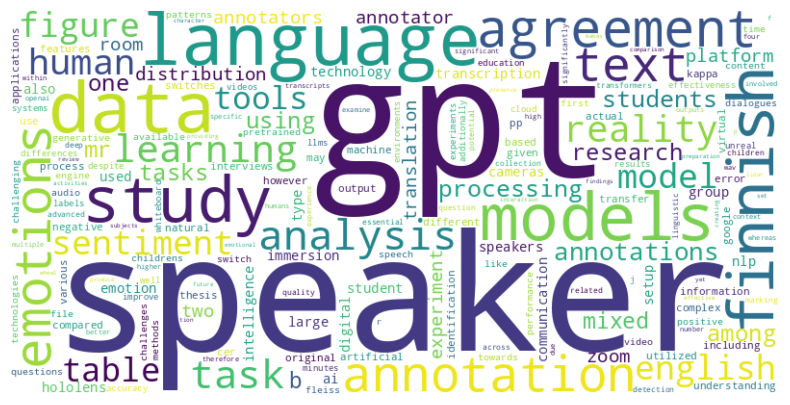

In [ ]:
import PyPDF2
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

# Ensure you have downloaded the stopwords
nltk.download('stopwords')

# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    pdf_reader = PyPDF2.PdfReader(open(pdf_path, 'rb'))
    text = ""
    for page_num in range(len(pdf_reader.pages)):
        page = pdf_reader.pages[page_num]
        text += page.extract_text()
    return text

# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'\d+|[^\w\s]', '', text)
    # Tokenize text
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return words

# Function to generate and display word cloud
def generate_word_cloud(words):
    word_counts = Counter(words)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Main function
def main(pdf_path):
    text = extract_text_from_pdf(pdf_path)
    words = preprocess_text(text)
    generate_word_cloud(words)

# Example usage
pdf_path = '/content/MSc_thesis___Maryam_Teimouri.pdf'  # Replace with your PDF file path
main(pdf_path)
